# PHASE 2 — Campaign, Channel & Impact Insights

## Loading Data

In [1]:
import pyodbc
import pandas as pd

conn = pyodbc.connect(
    "Driver={ODBC Driver 17 for SQL Server};"
    "Server=DESKTOP-L3GBMQ5\\SQLEXPRESS;"
    "Database=Q4 Multi-Channel Performance & Forecast Alignment Analysis;"
    "Trusted_Connection=yes;"
)


In [2]:
df_perf = pd.read_sql_query("SELECT * FROM Performance", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_4640\2164272931.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_perf = pd.read_sql_query("SELECT * FROM Performance", conn)


In [3]:
df_imp = pd.read_sql_query("SELECT * FROM product_impact", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_4640\904220287.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_imp = pd.read_sql_query("SELECT * FROM product_impact", conn)


In [4]:
df_fore = pd.read_sql("SELECT * FROM forecasting", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_4640\1651432634.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_fore = pd.read_sql("SELECT * FROM forecasting", conn)


In [5]:
df_daily = (df_perf
            .groupby(['date', 'channel_id', 'campaign_id'])
            .agg({'impressions': 'sum'
                  ,'clicks': 'sum'
                  ,'conversions': 'sum'
                  ,'spend': 'sum'
                  ,'revenue': 'sum'
}))

In [6]:
df_daily.rename(columns={'Date': 'date'}, inplace=True)

In [7]:

df_daily = (df_perf
            .groupby(['date', 'channel_id', 'campaign_id'])
            .agg({'impressions': 'sum'
                  ,'clicks': 'sum'
                  ,'conversions': 'sum'
                  ,'spend': 'sum'
                  ,'revenue': 'sum'
})
            .reset_index()
            )

In [8]:
df_daily.rename(columns={'Date': 'date'}, inplace=True)

In [9]:
df_master = pd.read_sql("SELECT * FROM master_daily", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_4640\3418188008.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_master = pd.read_sql("SELECT * FROM master_daily", conn)


---------------------------------------

## Campaing-Level Insights

Aggregate Campaign Performance

In [12]:
campaign_performance = pd.read_sql("""
SELECT
    campaign_id,
    SUM(spend) AS total_spend,
    SUM(revenue) AS total_revenue,
    SUM(clicks) AS total_clicks,
    SUM(conversions) AS total_conversions,
    AVG(CTR) AS avg_ctr,
    AVG(CVR) AS avg_cvr,
    SUM(revenue) / NULLIF(SUM(spend),0) AS poas,
    SUM(spend) / NULLIF(SUM(conversions),0) AS cpa
FROM master_daily
GROUP BY campaign_id
ORDER BY poas DESC;
""", conn)

C:\Users\GIGABYTE\AppData\Local\Temp\ipykernel_4640\1873052359.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  campaign_performance = pd.read_sql("""


In [13]:
campaign_performance.head()

,campaign_id,total_spend,total_revenue,total_clicks,total_conversions,avg_ctr,avg_cvr,poas,cpa
0,1027,114002915.0,5.203622e+07,743187,6006322,0.100535,8.766332,0.456446,18.980487
1,1008,115265076.0,5.260985e+07,750131,6055368,0.099907,8.814148,0.456425,19.035189
2,1010,115459176.0,5.262291e+07,745470,6090707,0.099031,8.742607,0.455771,18.956613
3,1009,114910929.0,5.236550e+07,742436,6029842,0.099602,8.822320,0.455705,19.057038
4,1014,114557946.0,5.182298e+07,730816,6077635,0.099031,8.671444,0.452374,18.849099


Campaign POAS Visualization

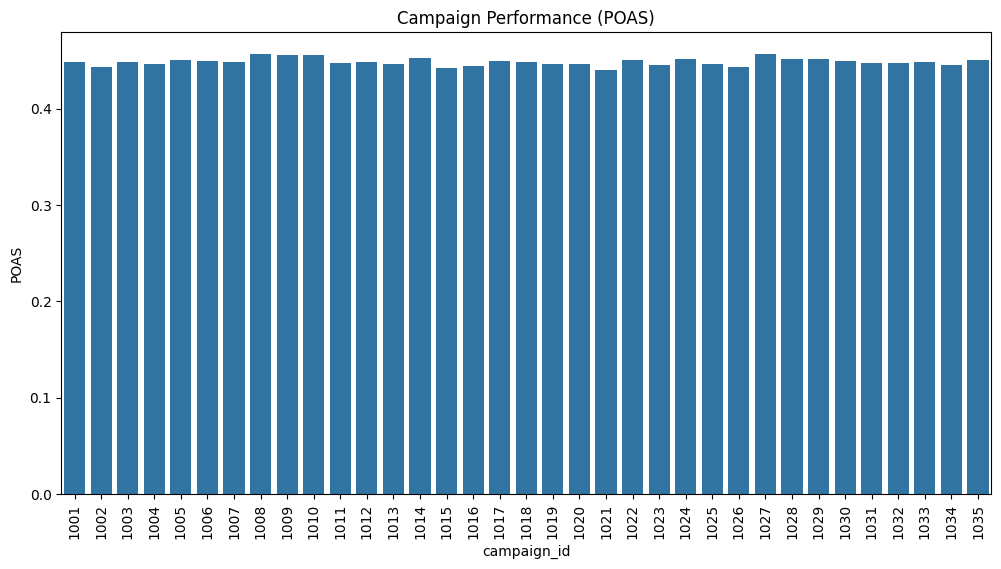

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.barplot(x=campaign_perf.index, y=campaign_perf["POAS"])
plt.title("Campaign Performance (POAS)")
plt.xticks(rotation=90)
plt.show()

_______________________

## Channel-Level Insights

In [18]:
channel_perf = (
    df_master.groupby("channel_id")
    .agg({
        "spend":"sum",
        "revenue":"sum",
        "clicks":"sum",
        "conversions":"sum",
        "CTR":"mean",
        "CVR":"mean"
    })
    .assign(
        POAS=lambda d: d["revenue"]/d["spend"],
        CPA=lambda d: d["spend"]/d["conversions"]
    )
    .sort_values("POAS", ascending=False)
)

channel_perf

,spend,revenue,clicks,conversions,CTR,CVR,POAS,CPA
channel_id,,,,,,,,
4,803222703.0,3.607761e+08,5154567,42398882,0.099005,8.628037,0.449161,18.944431
1,805040113.0,3.612465e+08,5160189,42633837,0.098961,8.584925,0.448731,18.882657
2,804303952.0,3.608165e+08,5153373,42439314,0.098836,8.616412,0.448607,18.951860
3,802485394.0,3.599050e+08,5149165,42356723,0.098945,8.605919,0.448488,18.945880
5,798102278.0,3.573053e+08,5101115,42393619,0.098687,8.542142,0.447694,18.826000


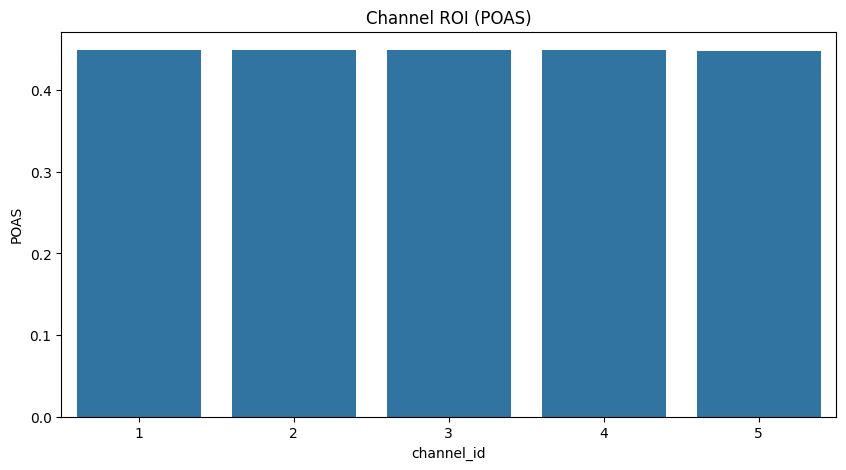

In [19]:
plt.figure(figsize=(10,5))
sns.barplot(x=channel_perf.index, y=channel_perf["POAS"])
plt.title("Channel ROI (POAS)")
plt.show()

__________________

## Impact Score Analysis

In [20]:
impact_corr = df_master[
    ["awareness_index","consideration_index","impact_score","clicks","conversions","revenue"]
].corr()

impact_corr

,awareness_index,consideration_index,impact_score,clicks,conversions,revenue
awareness_index,1.000000,0.618702,-0.091801,0.008275,-0.002221,0.007680
consideration_index,0.618702,1.000000,-0.028141,0.000228,0.000440,-0.002475
impact_score,-0.091801,-0.028141,1.000000,0.006071,0.008001,0.007638
clicks,0.008275,0.000228,0.006071,1.000000,-0.014923,0.861501
conversions,-0.002221,0.000440,0.008001,-0.014923,1.000000,-0.014254
revenue,0.007680,-0.002475,0.007638,0.861501,-0.014254,1.000000


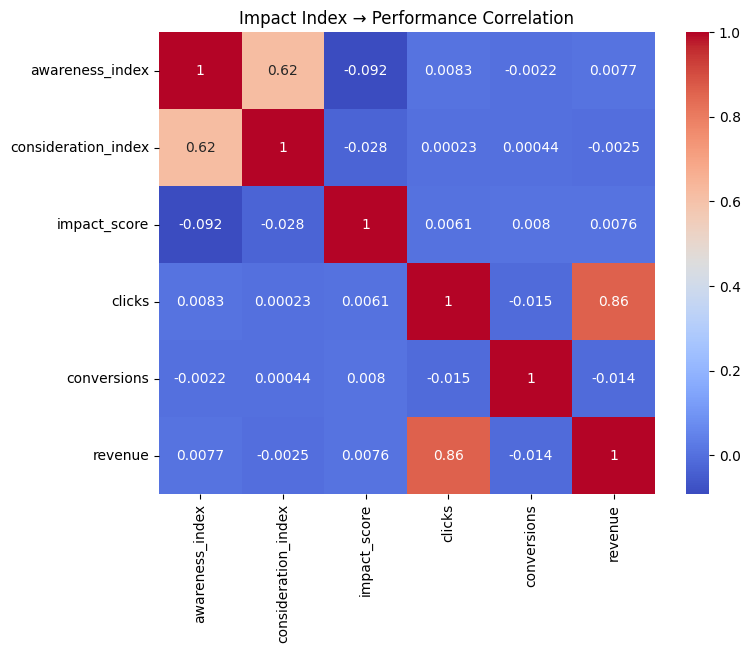

In [21]:
plt.figure(figsize=(8,6))
sns.heatmap(impact_corr, annot=True, cmap="coolwarm")
plt.title("Impact Index → Performance Correlation")
plt.show()


_____________

## Forecast Accuracy Summary

In [24]:
df_master["forecast_error"] = df_master["forecasted_revenue"] - df_master["revenue"]
df_master["forecast_pct_error"] = df_master["forecast_error"] / df_master["revenue"]


In [25]:
forecast_summary = df_master["forecast_error"].describe()
forecast_summary

count     21585.000000
mean     -83206.319898
std       19418.561521
min     -179442.799561
25%      -95310.949387
50%      -81719.039948
75%      -69486.669479
max      -27424.730118
Name: forecast_error, dtype: float64